# POP 0.1deg OMIP2 Simulation: Compute UOHC/UOSC Bias on 1x1 Grid

In [2]:
%matplotlib inline
import os
import shutil
from glob import glob
import cftime
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import intake
import cf_xarray
import pop_tools
#import xesmf as xe
import pangeo_xesmf as xe
#import esmlab
#import util
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pangeo_xesmf'

In [2]:
xe.__version__

'0.6.1'

In [4]:
xr.__version__

'0.19.0'

In [3]:
import dask
dask.__version__

'2021.09.0'

## Create Dask Cluster

In [115]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

In [75]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [76]:
cluster, client = get_ClusterClient()
cluster.scale(15) 

In [77]:
cluster

## Functions to compute depth-average

In [9]:
def limit_depth_of_field(level_bounds, field, depth_limit):
    level_bounds_limited = level_bounds.where(level_bounds < depth_limit, depth_limit)
    delta_level = abs(level_bounds_limited[:, 1] - level_bounds_limited[:, 0])
    delta_level_limited = delta_level.where(delta_level != 0, drop=True)
    field_limited = field.where(delta_level != 0, drop=True)
    return delta_level_limited, field_limited

def compute_depthavg_ds(ds,field,depth_coord,depth=100):
    """
    Compute mean over depth for field.
    """
    newvarname = field+'_'+str(depth)+'m_mean'
    dep_bnds = depth_coord+'_bnds'
    dz,data = limit_depth_of_field(ds[dep_bnds],ds[field],depth)
    data_mean = (data*dz).sum(depth_coord,skipna=False)/dz.sum(depth_coord)
    ds[newvarname] = data_mean
    ds[newvarname].attrs['units'] = data.attrs['units']
    return ds

# EN4 Observations

In [10]:
fin = '/glade/p/cgd/oce/people/yeager/OBS/MetOffice.EN4/v4.2.1/monthly/EN.4.2.1.f.analysis.g10.????.nc'
ds_en4 = xr.open_mfdataset(fin,chunks={'time':12},combine='by_coords',data_vars='minimal',parallel=True)

In [11]:
# Create 30-year monthly climatology
ds_en4 = ds_en4[['temperature','salinity','time_bnds','depth_bnds']].sel(time=slice('1978','2007'))

# Following line is needed to circumvent this xarray issue:
#  https://github.com/pydata/xarray/issues/2145#issuecomment-391114129
ds_en4 = ds_en4.set_coords('depth_bnds')

ds_en4 = ds_en4.groupby('time.month',squeeze=True).mean('time',keep_attrs=True)
ds_en4 = ds_en4.rename({'temperature':'thetao','salinity':'so'})
ds_en4 = ds_en4.load()

In [12]:
# Add depth-average fields to Dataset
ds_en4['thetao'] = ds_en4['thetao'] - 273.15
ds_en4['thetao'].attrs['units'] = 'degC'
ds_en4 = compute_depthavg_ds(ds_en4,'thetao','depth',200)
ds_en4 = compute_depthavg_ds(ds_en4,'so','depth',200)

In [13]:
# Write to netcdf
fout = '/glade/scratch/yeager/OMDP/EN4_1978-2007clim_200m.nc'
ds_en4 = ds_en4[['thetao_200m_mean','so_200m_mean']]
ds_en4.fillna(-9999).to_netcdf(fout,encoding={'thetao_200m_mean': {'dtype': 'float', '_FillValue': -9999},'so_200m_mean': {'dtype': 'float', '_FillValue': -9999}})

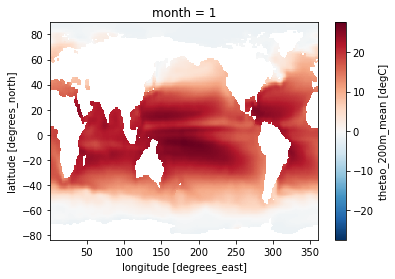

In [14]:
ds_en4['thetao_200m_mean'].isel(month=0).plot()

# Regrid EN4 data to standard 1x1 grid

In [16]:
# Define target grid
woa1x1 = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90.5, 1.0)),
                     'lon': (['lon'], np.arange(0.5, 360.5, 1.0))})

In [17]:
regrid_en4 = xe.Regridder(ds_en4, woa1x1, method='bilinear',periodic=True)
regrid_en4  # print basic regridder information.

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_173x360_180x360_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (173, 360) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

In [18]:
ds_en4_1x1 = regrid_en4(ds_en4,keep_attrs=True)
# Write to netcdf
fout = '/glade/scratch/yeager/OMDP/EN4_1978-2007clim_200m_1x1.nc'
ds_en4_1x1.to_netcdf(fout)

In [19]:
ds_en4_1x1

<xarray.Dataset>
Dimensions:           (month: 12, lat: 180, lon: 360)
Coordinates:
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lon               (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat               (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    thetao_200m_mean  (month, lat, lon) float32 nan nan nan ... -1.221 -1.22
    so_200m_mean      (month, lat, lon) float32 nan nan nan ... 33.42 33.42
Attributes: (12/23)
    Conventions:            CF-1.0
    title:                  Temperature and salinity analysis
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    references:             None
    institution:            UK Met Office
    contact:                Simon Good - simon.good@metoffice.gov.uk
    ...                     ...
    northernmost_latitude:  89.5
    westernmost_longitude:  0.5
    easternmost_longitude:  362.5
    file_quality_index:     0
    NCO:                    netCDF Operators version 4.9.5 (Homepage = http:/...
    regrid_method:          bilinear

## Process POP 0.1deg OMIP2 data 

In [25]:
def time_set_midmonth(ds, time_name):
    year = ds[time_name].dt.year
    month = ds[time_name].dt.month
    year = xr.where(month==1,year-1,year)
    month = xr.where(month==1,12,month-1)
    nmonths = len(month)
    newtime = [cftime.DatetimeNoLeap(year[i], month[i], 15) for i in range(nmonths)]
    ds[time_name] = newtime
    return ds

In [26]:
%%time
dir1 = '/glade/campaign/cesm/development/omwg/g.e20.G.TL319_t13.control.001/ocn/hist/'
filetemp = dir1+'g.e20.G.TL319_t13.control.001.pop.h.????-??.nc'
infiles = sorted(glob(filetemp))

CPU times: user 7.84 ms, sys: 3.08 ms, total: 10.9 ms
Wall time: 9.46 ms


In [27]:
len(infiles)

732

In [28]:
def open_POPfile(file,chunks):
    ds = time_set_midmonth(xr.open_dataset(file,chunks=chunks),'time')
    ds = ds[['TEMP','SALT','z_t','z_w']].isel(z_t=slice(0,21)).isel(z_w=slice(0,22))
    return ds

In [30]:
infiles[-1].split('/')[-1]

'g.e20.G.TL319_t13.control.001.pop.h.0061-12.nc'

## First, define POP0.1 to 1x1 Regridder

In [48]:
%%time
ds = open_POPfile(infiles[0],{'z_t':4})
ds['z_t'] = ds['z_t']/100.
ds['z_t'].attrs['units'] = 'm'
ds['z_w'] = ds['z_w']/100.
ds['z_w'].attrs['units'] = 'm'
ztbnds = np.transpose(np.array([ds['z_w'].values[0:-1],ds['z_w'].values[1:]]))
tmp = xr.DataArray(ztbnds,dims=['z_t','nbnds'],coords={'z_t':ds['z_t']})
ds['z_t_bnds'] = tmp
ds = ds.rename({'TEMP':'thetao','SALT':'so'})
ds = compute_depthavg_ds(ds,'thetao','z_t',200)
ds = compute_depthavg_ds(ds,'so','z_t',200)
ds = ds.drop(['ULONG','ULAT','thetao','so'])
ds = ds.rename({'TLAT':'latitude','TLONG':'longitude'})

CPU times: user 93.2 ms, sys: 3.02 ms, total: 96.3 ms
Wall time: 94.5 ms


In [33]:
ds

<xarray.Dataset>
Dimensions:           (z_t: 21, z_w: 22, time: 1, nlat: 2400, nlon: 3600, nbnds: 2)
Coordinates:
  * z_t               (z_t) float32 5.0 15.0 25.0 35.0 ... 186.3 197.7 209.7
  * z_w               (z_w) float32 0.0 10.0 20.0 30.0 ... 191.8 203.5 215.9
  * time              (time) object 0001-01-15 00:00:00
    longitude         (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    latitude          (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, nbnds
Data variables:
    z_t_bnds          (z_t, nbnds) float32 0.0 10.0 10.0 ... 203.5 203.5 215.9
    thetao_200m_mean  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    so_200m_mean      (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    title:             g.e20.G.TL319_t13.control.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89091 2018-04-30 15:58:32Z altuntas@ucar...
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-07-13 at 10:47:09.6
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [35]:
%%time
HRPOPregridder = xe.Regridder(ds, woa1x1, method='bilinear')

CPU times: user 1min 22s, sys: 1.04 s, total: 1min 23s
Wall time: 1min 21s


In [50]:
ds1x1 = HRPOPregridder(ds.load())

In [51]:
%%time
for infile in infiles:
    cdffile = infile.split('/')[-1]
    outfile='/glade/scratch/yeager/iHESP/'+cdffile
    if (not os.path.exists(outfile)):
        print(cdffile)
        ds = open_POPfile(infile,{'z_t':4})
        ds['z_t'] = ds['z_t']/100.
        ds['z_t'].attrs['units'] = 'm'
        ds['z_w'] = ds['z_w']/100.
        ds['z_w'].attrs['units'] = 'm'
        ztbnds = np.transpose(np.array([ds['z_w'].values[0:-1],ds['z_w'].values[1:]]))
        tmp = xr.DataArray(ztbnds,dims=['z_t','nbnds'],coords={'z_t':ds['z_t']})
        ds['z_t_bnds'] = tmp
        ds = ds.rename({'TEMP':'thetao','SALT':'so'})
        ds = compute_depthavg_ds(ds,'thetao','z_t',200)
        ds = compute_depthavg_ds(ds,'so','z_t',200)
        ds = ds.drop(['ULONG','ULAT','thetao','so'])
        ds = ds.rename({'TLAT':'latitude','TLONG':'longitude'})
        ds1x1 = HRPOPregridder(ds.load())
        ds1x1.to_netcdf(outfile)

g.e20.G.TL319_t13.control.001.pop.h.0001-01.nc
g.e20.G.TL319_t13.control.001.pop.h.0001-02.nc
g.e20.G.TL319_t13.control.001.pop.h.0001-03.nc
g.e20.G.TL319_t13.control.001.pop.h.0001-04.nc
g.e20.G.TL319_t13.control.001.pop.h.0001-05.nc
g.e20.G.TL319_t13.control.001.pop.h.0001-06.nc
g.e20.G.TL319_t13.control.001.pop.h.0001-07.nc
g.e20.G.TL319_t13.control.001.pop.h.0001-08.nc
g.e20.G.TL319_t13.control.001.pop.h.0001-09.nc
g.e20.G.TL319_t13.control.001.pop.h.0001-10.nc
g.e20.G.TL319_t13.control.001.pop.h.0001-11.nc
g.e20.G.TL319_t13.control.001.pop.h.0001-12.nc
g.e20.G.TL319_t13.control.001.pop.h.0002-01.nc
g.e20.G.TL319_t13.control.001.pop.h.0002-02.nc
g.e20.G.TL319_t13.control.001.pop.h.0002-03.nc
g.e20.G.TL319_t13.control.001.pop.h.0002-04.nc
g.e20.G.TL319_t13.control.001.pop.h.0002-05.nc
g.e20.G.TL319_t13.control.001.pop.h.0002-06.nc
g.e20.G.TL319_t13.control.001.pop.h.0002-07.nc
g.e20.G.TL319_t13.control.001.pop.h.0002-08.nc
g.e20.G.TL319_t13.control.001.pop.h.0002-09.nc
g.e20.G.TL319

# Compute OMIP UOHC & UOSC anomalies

## Read in regridded UOHC/UOSC from FOSI-HR

In [100]:
filetemp = '/glade/scratch/yeager/iHESP/g.e20.G.TL319_t13.control.001.pop.h.????-??.nc'

In [107]:
ds_hr1x1 = xr.open_mfdataset(filetemp,parallel=True,combine='by_coords')

In [108]:
ds_hr1x1

<xarray.Dataset>
Dimensions:           (time: 732, lat: 180, lon: 360, z_t: 21, z_w: 22)
Coordinates:
  * z_t               (z_t) float32 5.0 15.0 25.0 35.0 ... 186.3 197.7 209.7
  * z_w               (z_w) float32 0.0 10.0 20.0 30.0 ... 191.8 203.5 215.9
  * time              (time) object 0001-01-15 00:00:00 ... 0061-12-15 00:00:00
  * lon               (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat               (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    thetao_200m_mean  (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    so_200m_mean      (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [109]:
hrt200 = ds_hr1x1.thetao_200m_mean.load()
hrs200 = ds_hr1x1.so_200m_mean.load()

In [110]:
hrt200 = xr.where(hrt200 > 1.e20,np.nan,hrt200)
hrs200 = xr.where(hrs200 > 1.e20,np.nan,hrs200)

In [111]:
%%time
ncyc=4
nyear=61
yearrange=(1958,2018)
nyr = yearrange[1]-yearrange[0]+1
climrange = (1978,2007)
entryid = 'OMIP.iHESP.CESM13.omip2'
varname = entryid+'_thetao_0-200m_bias'
attrs = {'forcing_cycle':yearrange,'ncycle':1,'nominal_resolution':'10 km'}
nmon=732
cyc_time = [cftime.DatetimeNoLeap(yearrange[0]+year, 1+month, 15) for year in range(nyr) for month in range(12)]
hrt200['time'] = cyc_time
hrs200['time'] = cyc_time
hrt200 = hrt200.sel(time=slice(str(climrange[0]),str(climrange[1])))
hrt200_clim = hrt200.groupby('time.month').mean('time',keep_attrs=True)
hrt200_climbias = hrt200_clim - ds_en4_1x1['thetao_200m_mean']
hrs200 = hrs200.sel(time=slice(str(climrange[0]),str(climrange[1])))
hrs200_clim = hrs200.groupby('time.month').mean('time',keep_attrs=True)
hrs200_climbias = hrs200_clim - ds_en4_1x1['so_200m_mean']

CPU times: user 234 ms, sys: 1.34 ms, total: 236 ms
Wall time: 223 ms


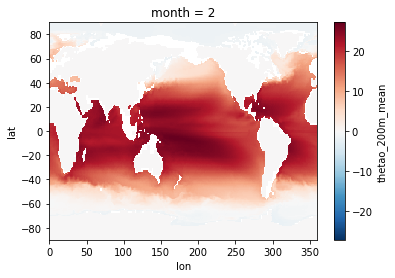

In [112]:
hrt200.groupby('time.month').mean('time',skipna=True).isel(month=1).plot()

In [113]:
hrt200_climbias.name = entryid+'_thetao_0-200m_bias'
hrt200_climbias = hrt200_climbias.assign_coords({'cycle':1})
hrt200_climbias = hrt200_climbias.expand_dims({'member_id':1},axis=1)
hrt200_climbias.attrs = attrs

hrs200_climbias.name = entryid+'_so_0-200m_bias'
hrs200_climbias = hrs200_climbias.assign_coords({'cycle':1})
hrs200_climbias = hrs200_climbias.expand_dims({'member_id':1},axis=1)
hrs200_climbias.attrs = attrs

In [114]:
ds_out = xr.Dataset({hrt200_climbias.name:hrt200_climbias,hrs200_climbias.name:hrs200_climbias,
                    hrt200_clim.name:hrt200_clim,hrs200_clim.name:hrs200_clim})
ds_out.to_netcdf('/glade/scratch/yeager/OMDP/POP0.1.OMIP2.T200.S200.climbias.nc')

In [68]:
ds_out

<xarray.Dataset>
Dimensions:                                     (lon: 360, lat: 180, month: 12, member_id: 1)
Coordinates:
  * lon                                         (lon) float64 0.5 1.5 ... 359.5
  * lat                                         (lat) float64 -89.5 ... 89.5
  * month                                       (month) int64 1 2 3 ... 10 11 12
    cycle                                       int64 1
Dimensions without coordinates: member_id
Data variables:
    OMIP.iHESP.CESM13.omip2_thetao_0-200m_bias  (month, member_id, lat, lon) float32 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    OMIP.iHESP.CESM13.omip2_so_0-200m_bias      (month, member_id, lat, lon) float32 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>

In [70]:
hrt200_clim

<xarray.DataArray 'thetao_200m_mean' (month: 12, lat: 180, lon: 360)>
dask.array<stack, shape=(12, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12